In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time
from ocean_navigation_simulator.generative_error_model.GAN.data_postprocessing import ConvertToError, get_sparse_from_nc

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# Compute RMSE

File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-22T12:30:00,2022-09-30T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-23T12:30:00,2022-10-01T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-24T12:30:00,2022-10-02T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-25T12:30:00,2022-10-03T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-26T12:30:00,2022-10-04T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-27T12:30:00,2022-10-05T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-28T12:30:00,2022-10-06T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-29T12:30:00,2022-10-07T11:30:00 already exists!
File: GAN_

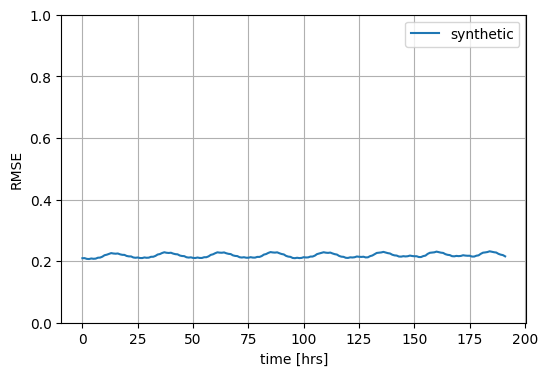

In [8]:
# write nc files from raw GAN predictions
predictions_dir = "../../../data/drifter_data/GAN_samples/2022-11-28_20:38:37"
ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_test/area1"
eval = ConvertToError(predictions_dir, ground_truth_dir)
error_root = "../../../data/drifter_data/GAN_nc/errors"
eval.get_individual_as_nc(error_root, type="error")

# load nc files
files = os.listdir(file_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(file_root, file), engine="netcdf4")
    rmse.append(rmse_over_time_xr(data, variables=("water_u", "water_v")))
rmse = np.array(rmse).mean(axis=0)

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(rmse)), rmse, label="synthetic")
plt.ylim([0, 1.0])
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()
plt.legend()

# Compute Vector Correlation

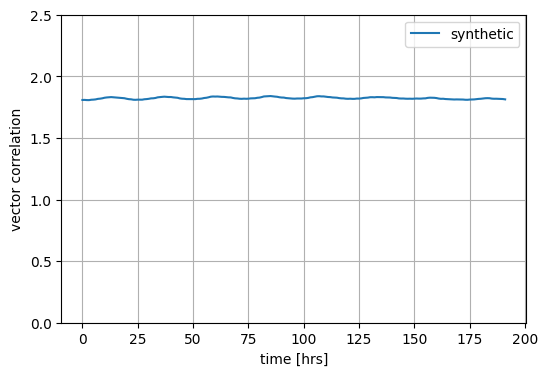

In [24]:
# predicted currents vs forecast

# # write nc file for forecasts from raw GAN output
# eval = ConvertToError(predictions_dir, ground_truth_dir)
# forecast_root = "../../../data/drifter_data/GAN_nc/forecasts"
# eval.get_individual_as_nc(file_root_fc, type="current")

# load nc files
error_files = sorted(os.listdir(error_root))
forecast_files = sorted(os.listdir(forecast_root))

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(vec_corr)), vec_corr, label="synthetic")
plt.ylim([0, 2.5])
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()
plt.legend()

# Compute Variogram

In [5]:
# get sparse samples

predictions_dir = "../../../data/drifter_data/GAN_samples/2022-11-28_20:38:37"
ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_test/area1"
eval = ConvertToError(predictions_dir, ground_truth_dir)
ds = eval.get_max_volume_as_nc()
output_path = "../../../data/drifter_data/GAN_nc/sample_volume.nc"
ds.to_netcdf(output_path)

data = get_sparse_from_nc(output_path)
data

(552, 2, 256, 256)


,lon,lat,time,u_error,v_error
0,-134.166667,27.833333,2022-10-07 00:30:00,0.000000,0.000000
1,-141.25,29.083333,2022-10-14 07:30:00,0.000000,0.000000
2,-126.416667,17.916667,2022-09-26 09:30:00,0.071127,-0.212089
3,-136.166667,31.833333,2022-09-28 21:30:00,0.016346,0.069963
4,-125.0,25.333333,2022-09-26 00:30:00,-0.314039,0.069663
...,...,...,...,...,...
29995,-128.583333,30.5,2022-10-09 06:30:00,0.000000,0.000000
29996,-142.666667,15.166667,2022-10-08 09:30:00,0.000000,0.000000
29997,-134.5,32.083333,2022-10-05 18:30:00,0.101265,-0.021257
29998,-143.5,32.666667,2022-10-09 19:30:00,0.000000,0.000000


In [6]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

# compute variogram
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)

array([<AxesSubplot:xlabel='space_lag [km]', ylabel='Semivariance'>,
       <AxesSubplot:xlabel='t_lag [hrs]', ylabel='Semivariance'>],
      dtype=object)

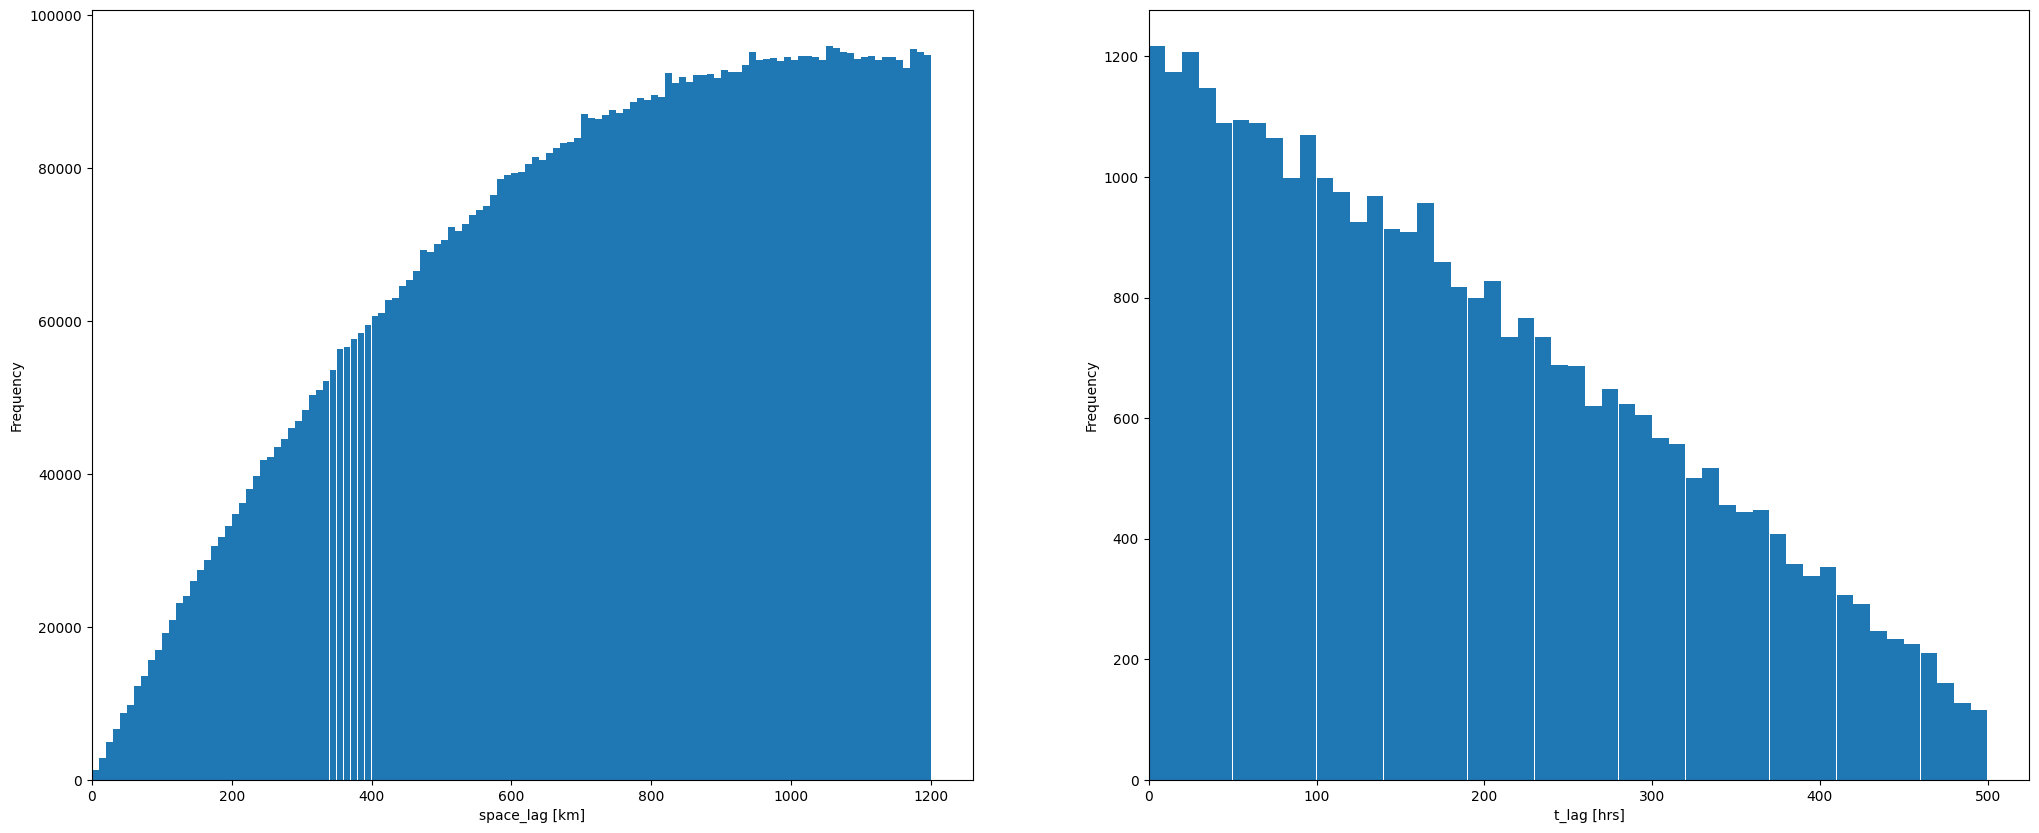

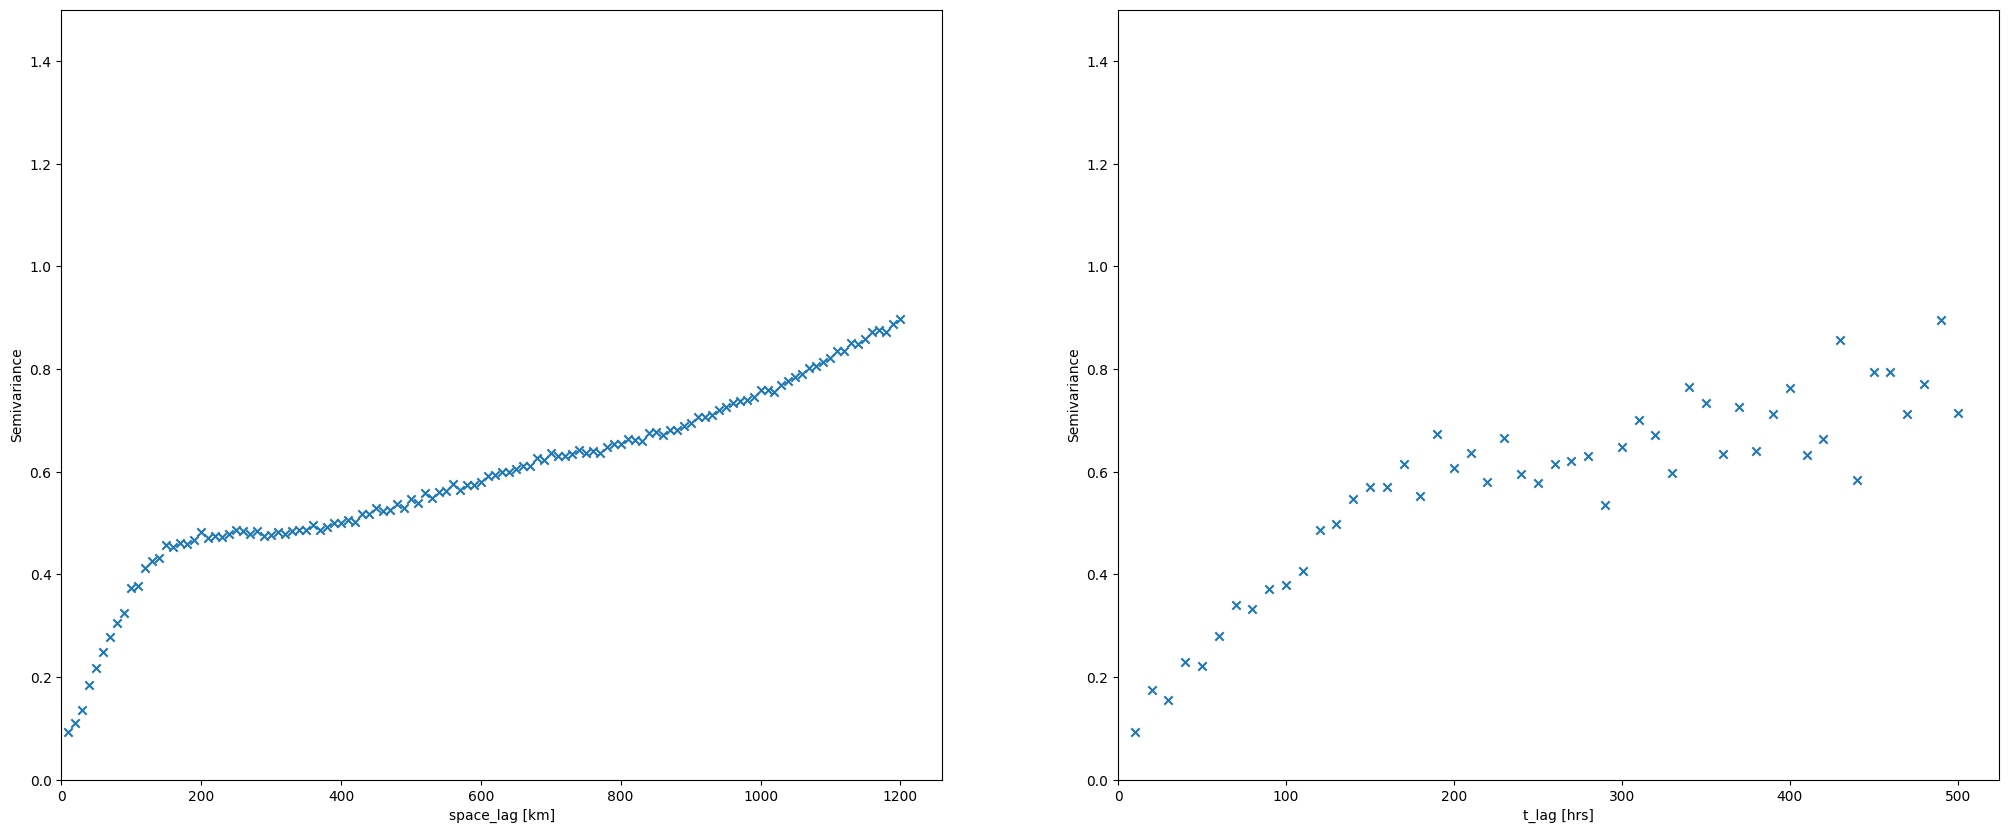

In [12]:
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [1200, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(error_variable="u", view_range=view_range)